## Parking process on $\mathbb{Z}/N\mathbb{Z}$ simulation

In [61]:
# A script to simulate the parking process on a graph.

import random
import numpy as np
import copy
from math import *
import matplotlib.pyplot as plt
from tqdm import trange


# Let's introduce the basic parking process dynamics on Z/NZ, starting with probability p of having a car, and all remaining sites
# are parking spots.

# Generate an initial configuration vector on Z/NZ. +1 represents a car, while -1 will represent a parking spot. So we reserve
# 0 for a spot that initially had a car, but is vacant, or a spot that was filled by a car.

# 'Variant' index: p = standard parking, pa = parking with annihilation, pc = parking with coalescence,
# pb = parking with branching, pba = parking with branching and annihilation, pbc = parking with branching and coalescence.

# Not sure that

# A function to return a random index sampled from a vector [p_0, p_1, ... p_n]. Namely, return i with probability p_i / sum(p_i).
def discrete_sample(vec):
    nonneg_vec = copy.copy(vec)
    for i in range(len(vec)):
        if vec[i] < 0:
            nonneg_vec[i] = 0

    a = random.random()
    s = sum(nonneg_vec)
    b = nonneg_vec[0] / s
    i = 0
    while b < a:
        i += 1
        b += nonneg_vec[i] / s
    return(i)


class config:
    def __init__(self, N, p, variant):
        self.length = N
        self.carprob = p
        self.variant = variant
        self.state = []
        self.cars = 0
        self.spots = 0

        # Generate the initial configuration.
        j = 0
        while j < N:
            j += 1
            w = random.random()
            if w < p:
                self.state.append(1)
                self.cars += 1
            else:
                self.state.append(-1)
                self.spots += 1

    # A car at site i parks at site j.
    def park(self, i, j):
        self.state[i] -= 1
        self.state[j] = 0
        self.cars -= 1
        self.spots -= 1

    # A car at site i annihilates a car at site j.
    def annihilate(self, i, j):
        self.state[i] -= 1
        self.state[j] -= 1
        self.cars -= 2

    # A car at site i coalesces with cars at site j.
    def coalesce(self, i, j):
        self.state[i] -= 1
        self.cars -= 1

    # A car at site i drives to site j.
    def drive(self, i, j):
        self.state[i] -= 1
        self.state[j] += 1

    # Update the configuration by toppling at a random site.
    def topple(self):
        if self.cars == 0:
            # print('stable')
            return False
        else:
            x = discrete_sample(self.state)

            w = random.random()
            if w < 1 / 2:
                y = (x + 1) % self.length
            else:
                y = (x - 1) % self.length

            target = self.state[y]

            if self.variant == 'p':
                if target == -1:
                    self.park(x,y)
                else:
                    self.drive(x,y)

            elif self.variant == 'pa':
                if target == -1:
                    self.park(x,y)

                elif target == 0:
                    self.drive(x,y)

                elif target == 1:
                    self.annihilate(x,y)

            elif self.variant == 'pc':
                if target == -1:
                    self.park(x,y)

                elif target == 0:
                    self.drive(x,y)

                elif target > 0:
                    self.coalesce(x,y)

            return True


# Statistical test for criticality. Vary the value of p, and check: did every spot eventually get parked in?
def criticality_stats(N, delta_p, pmin, pmax, trials, variant):
    p_range = int((pmax - pmin) * delta_p**(-1))
    parked_data = [0] * p_range
    for j in trange(p_range):
        p = pmin + j * delta_p
        print(p)
        for s in range(int(trials)):
            u = config(N, p, variant)
            while u.spots > 0 and u.cars > 0:
                u.topple()

            if u.spots == 0:
                parked_data[j] += 1.0 / trials

    return parked_data



# Run a single instance of the process. Good for debugging.
def single_sim(N, p, variant, iterations=None):
    u = config(N, p, variant)
    #print(u.state)
    history = []
    history_states = []
    iteration=0
    while u.spots > 0 and u.cars > 0:
        u.topple()
        #print(u.state, u.spots, u.cars)
        #print(u.spots, u.cars)
        iteration += 1
        if iteration % 10 == 0:
            history.append([u.cars, u.spots])
            history_states.append(u.state.copy())
        if (iterations is not None) and (iteration==iterations):
            break
            
        
    #print("[cars, spots]")
    return np.asarray(history_states)


# How does the number of active cars decay over time?
def odometer_stats(N, p, T, trials, variant):
    density_data = [0] * T
    for s in range(trials):
        u = config(N, p, variant)
        for t in range(T):
            density_data[t] += u.cars / (N * trials)
            u.topple()

    return(density_data)


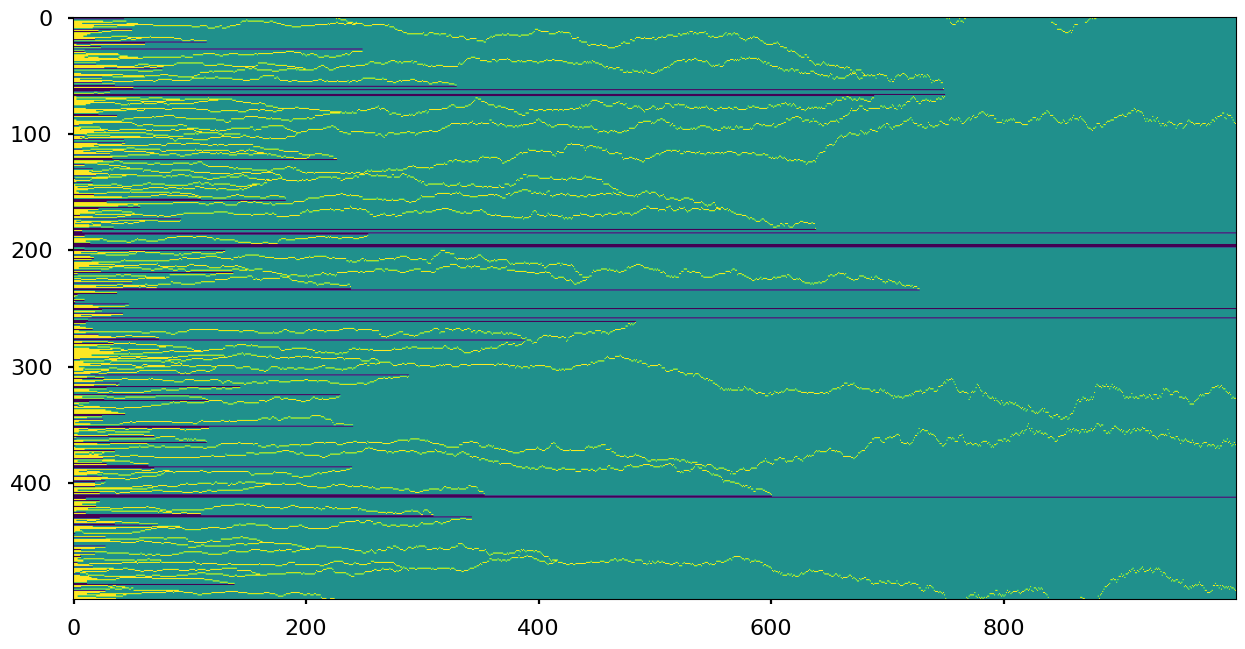

In [77]:
# generate trajectory 
N= 500
p=0.7
variant = 'pc' # parking with coalescence
history = single_sim(N, p, variant, iterations=10000)

# make plot
fig = plt.figure(figsize=[15,15], constrained_layout=False)
ax = plt.subplot(1, 1, 1)
ax.imshow(history.T)

In [28]:

# Odometer stat calculator, for various values of p.
# N = 30
# T = 200
# trials = 1000
# data = odometer_stats(N, .5, T, trials, 'p')
# data2 = odometer_stats(N, .45, T, trials, 'p')
# data3 = odometer_stats(N, .2, T, trials, 'p')
# data4 = odometer_stats(N, .75, T, trials, 'p')
# plt.plot(range(T), data, 'r', range(T), data2, 'b', range(T), data3, 'g', range(T), data4, 'm')
# plt.show()

# # Critical window plot.
a = .7
b = .9
dp = .02
N = 2000
T = 5

data = criticality_stats(N, dp, a, b, T, 'pc')
plt.plot(data)
plt.show()

# Crit stats with N = 2000 and T = 5 gave P(all spots dead) ~ .5 when p ~ .785.

########################################################################################################################
########################################################################################################################
#Networkx experimentation###############################################################################################
########################################################################################################################
########################################################################################################################

import networkx as nx
G = nx.Graph()

# TODO: parking process given an arbitrary adjacency matrix...

  0%|                                                    | 0/10 [00:00<?, ?it/s]

0.7


  0%|                                                    | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: 

## Mean field ODE

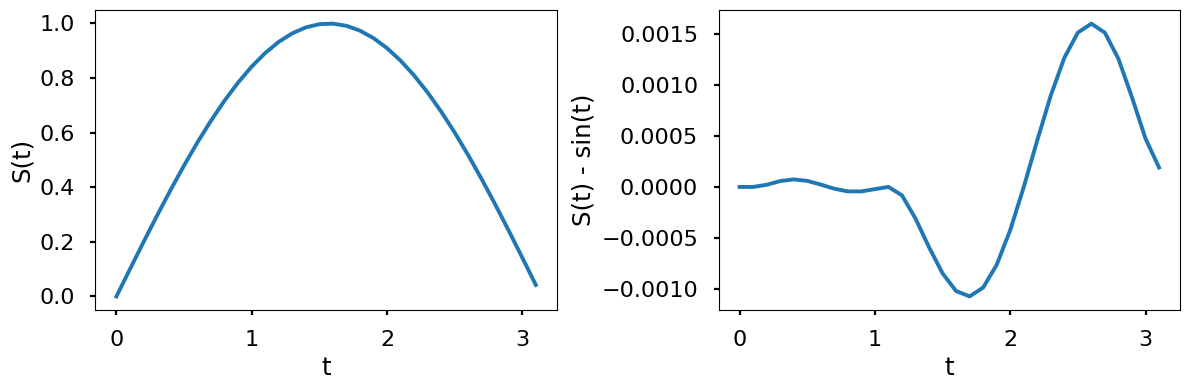

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

plt.style.use('seaborn-poster')

%matplotlib inline

F = lambda t, s: np.cos(t)

t_eval = np.arange(0, np.pi, 0.1)
sol = solve_ivp(F, [0, np.pi], [0], t_eval=t_eval)

plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.plot(sol.t, sol.y[0])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.subplot(122)
plt.plot(sol.t, sol.y[0] - np.sin(sol.t))
plt.xlabel('t')
plt.ylabel('S(t) - sin(t)')
plt.tight_layout()
plt.show()

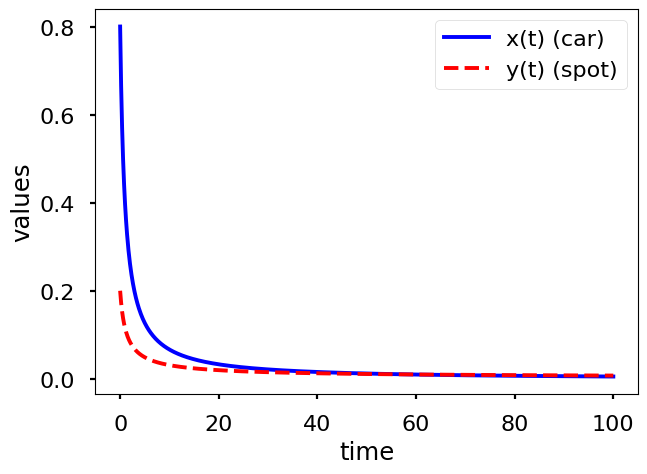

In [76]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dz/dt
def model(z,t,r=1):
    x = z[0]
    y = z[1]
    dxdt = -x*y - r*(x**2)
    dydt = -x*y
    dzdt = [dxdt,dydt]
    return dzdt

# initial condition
p = 0.2
z0 = [1-p, p]

# number of time points
n = 1000

# time points
t = np.linspace(0,100,n)

# step input

# store solution
x = np.empty_like(t)
y = np.empty_like(t)
# record initial conditions
x[0] = z0[0]
y[0] = z0[1]

# solve ODE
for i in range(1,n):
    # span for next time step
    tspan = [t[i-1],t[i]]
    # solve for next step
    z = odeint(model,z0,tspan)
    # store solution for plotting
    x[i] = z[1][0]
    y[i] = z[1][1]
    # next initial condition
    z0 = z[1] 

# plot results
fig = plt.figure(figsize=[7,5], constrained_layout=False)
plt.plot(t,x,'b-',label='x(t) (car)')
plt.plot(t,y,'r--',label='y(t) (spot)')
plt.ylabel('values')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()